In [2]:
from pybaseball import playerid_lookup
from pybaseball import statcast_pitcher

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## Part 1: Data Loading
- Lookup player info table
- Get MLB player id value

In [105]:
info_table = playerid_lookup('ohtani', 'shohei')

print(info_table)

# get MLB player id value
player_id = info_table.at[0,'key_mlbam']
print('-------------------------------')

# load pitch data
df = statcast_pitcher('2020-05-01', '2023-10-30', player_id)

  name_last name_first  key_mlbam key_retro  key_bbref  key_fangraphs  \
0    ohtani     shohei     660271  ohtas001  ohtansh01          19755   

   mlb_played_first  mlb_played_last  
0            2018.0           2023.0  
-------------------------------
Gathering Player Data


## Part 2: Data Preprocessing
- Reorgarnize the dataset only with wanted column.
- One-Hot Encoding for "on_1b", "on_2b", "on_3b"
- As runners info contains a lot of nan and now it's encoded, drop rows with nan value.
- Create new feature 'score_difference' by 'fld_score' - 'bat_score'
- Get a pitch_type list and map it to pitch_type list's index
- For pitch types that proportion is less than 3%, drop those pitch types to improve model accuracy.
- One-Hot Encoding for 'stand' attribute.

In [106]:
# extracting columns that are only wanted
df = df[['pitch_type', 'stand', 'balls', 'strikes',  'on_3b',  'on_2b', 'on_1b', 'outs_when_up', 'inning',
 'pitch_number', 'bat_score', 'fld_score']]

# base ruuner mapping
for i in range (0, len(df["on_1b"].axes[0])): #on the first base
    if df.loc[i,"on_1b"] > 0: # if there is any value, map it to 1
        df.at[i,"on_1b"] = 1.0
    else: # if not, to 0
        df.at[i,"on_1b"] = 0.0
        
for i in range (0, len(df["on_2b"].axes[0])): #on the second base
    if df.loc[i,"on_2b"] > 0: # if there is any value, map it to 1
        df.at[i,"on_2b"] = 1.0
    else: # if not, to 0
        df.at[i,"on_2b"] = 0.0
        
for i in range (0, len(df["on_3b"].axes[0])): #on the third base
    if df.loc[i,"on_3b"] > 0:# if there is any value, map it to 1
        df.at[i,"on_3b"] = 1.0
    else: # if not, to 0
        df.at[i,"on_3b"] = 0.0

# drop rows with nan values
df = df.dropna()

# create new feature 'score_difference' and drop columns un-needed
df["score_difference"] = df["fld_score"] - df["bat_score"]
df.drop(["fld_score", "bat_score"], axis=1, inplace=True)

# get a pitch type of the pitcher
pt_list = df['pitch_type'].unique()

# print pitch arsenal percentage
print("Original pitch aresnal\n")
print(df['pitch_type'].value_counts(normalize=True) * 100)

# drop pitch types that has been thrown less than 3%
pt_filter = df.pitch_type.value_counts(normalize=True) > 0.03
pt_index = pt_filter[pt_filter.values == True].index
df = df[df.pitch_type.isin(list(pt_index))]

# let's see how it has changed
print("\n\nHow it has changed\n")
ptm_list = df['pitch_type'].unique()
print(ptm_list)
print(len(ptm_list))
print(df['pitch_type'].value_counts(normalize=True) * 100)

# mapping pitch_type with index of'pt_list'
for i in range (0, len(ptm_list)):
    if i > len(ptm_list): break
    df['pitch_type'].mask(df['pitch_type'] == ptm_list[i] , i+1 , inplace=True)

# create temporary dataframe for previous pitch tendency dataframe
pre_df = pd.DataFrame(0, index=np.arange(df.shape[0]), columns=['pre1', 'pre2', 'pre3'])

# to prevent 'key error'
# the iteration will be made based on the number of the rows in 'pre_df', which is same as 'df'
num = pre_df.shape[0]

# concatenate these two dataframes
df = pd.concat([df, pre_df], axis=1)

# loop
for i in range (0, num): 
    if float(df.loc[i, "pitch_number"]) == 2: # when the pitch number is 2
        df.at[i, "pre1"] = df.loc[i + 1, "pitch_type"]
    elif float(df["pitch_number"][i]) == 3: # when the pitch number is 3
        df.at[i, "pre1"] = df.loc[i + 1, "pitch_type"]
        df.at[i, "pre2"] = df.loc[i + 2, "pitch_type"]
    elif float(df["pitch_number"][i]) > 3: # when the pitch number is bigger than 3
        df.at[i, "pre1"] = df.loc[i + 1, "pitch_type"]
        df.at[i, "pre2"] = df.loc[i + 2, "pitch_type"]
        df.at[i, "pre3"] = df.loc[i + 3, "pitch_type"]

# one-hot encoding for 'stand' as it is categorical data
stand_df = pd.get_dummies(df.stand, prefix='stand')
df.drop(["stand"], axis=1, inplace=True)
df = pd.concat([df, stand_df], axis=1)

df = df.dropna()

df.head(40)

Original pitch aresnal

FF    33.103680
ST    32.280289
FS    13.056629
FC    11.023357
CU     5.595698
SI     3.612838
SL     1.310704
CS     0.016804
Name: pitch_type, dtype: float64


How it has changed

['FF' 'FC' 'ST' 'SI' 'FS' 'CU']
6
FF    33.549046
ST    32.714578
FS    13.232289
FC    11.171662
CU     5.670981
SI     3.661444
Name: pitch_type, dtype: float64


,pitch_type,balls,strikes,on_3b,on_2b,on_1b,outs_when_up,inning,pitch_number,score_difference,pre1,pre2,pre3,stand_L,stand_R
0,1,0.0,0.0,1.0,0.0,1.0,1.0,5.0,1.0,0.0,0.0,0.0,0.0,1,0
1,2,3.0,2.0,0.0,1.0,1.0,1.0,5.0,7.0,1.0,3.0,1.0,2.0,0,1
2,3,2.0,2.0,0.0,1.0,1.0,1.0,5.0,6.0,1.0,1.0,2.0,1.0,0,1
3,1,1.0,2.0,0.0,1.0,1.0,1.0,5.0,5.0,1.0,2.0,1.0,1.0,0,1
4,2,1.0,2.0,0.0,1.0,1.0,1.0,5.0,4.0,1.0,1.0,1.0,2.0,0,1
5,1,0.0,2.0,0.0,1.0,1.0,1.0,5.0,3.0,1.0,1.0,2.0,0.0,0,1
6,1,0.0,1.0,0.0,1.0,1.0,1.0,5.0,2.0,1.0,2.0,0.0,0.0,0,1
7,2,0.0,0.0,0.0,1.0,1.0,1.0,5.0,1.0,1.0,0.0,0.0,0.0,0,1
8,1,1.0,1.0,0.0,0.0,1.0,1.0,5.0,3.0,1.0,2.0,4.0,0.0,0,1
9,2,1.0,0.0,0.0,0.0,1.0,1.0,5.0,2.0,1.0,4.0,0.0,0.0,0,1


## Just used RandomizedSearchCV() instead of butre forcing various hyperparameter combinations

In [107]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier
from scipy.stats import uniform as sp_randFloat
from scipy.stats import randint as sp_randInt
from sklearn.model_selection import RandomizedSearchCV

In [108]:
model = GradientBoostingClassifier(random_state=1)

X=df[['balls', 'strikes','on_3b', 'on_2b', 'on_1b', 'outs_when_up', 'inning', 'pitch_number', 'score_difference', 'pre1', 'pre2', 'pre3','stand_L', 'stand_R']]  # Features
y=df['pitch_type']  # Labels
y=y.astype('float')
        

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

parameters = {"subsample": sp_randFloat(),
              "n_estimators": sp_randInt(100, 800),
              "max_depth": sp_randInt(3, 10),
              "learning_rate": sp_randFloat()
              }

best_model = RandomizedSearchCV(estimator=model, param_distributions=parameters,
                           cv=3, n_iter=100, n_jobs=-1)
best_model.fit(X_train, y_train)

print("Results from Random Search ")
print(" The best estimator across ALL searched params:", best_model.best_estimator_)
print("\n   The best score across ALL searched params:", best_model.best_score_)

Results from Random Search 
 The best estimator across ALL searched params: GradientBoostingClassifier(learning_rate=0.09034731372581495, n_estimators=221,
                           random_state=1, subsample=0.9293082899322179)

   The best score across ALL searched params: 0.42406320496696015


## See the best model's confusion matrix and precision score

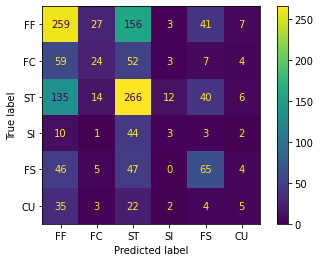

Precision Score= 0.32813918251325935
F1: 0.29749705480618716
Accuracy: 0.4392655367231638


In [109]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, precision_score, f1_score, accuracy_score
import matplotlib.pyplot as plt

predictions = best_model.predict(X_test)
cm = confusion_matrix(y_test, predictions, labels=best_model.classes_)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=ptm_list)
disp.plot()

plt.show()

p = precision_score(y_test, predictions, average='macro')
print("Precision Score=", p)
print('F1:',f1_score(y_test, predictions, average='macro'))
print('Accuracy:',accuracy_score(y_test, predictions))

## Save the model of the pitcher

In [110]:
import joblib

# save the model
joblib.dump(best_model, f'{player_id}.pkl')

['/Users/junyoung/Desktop/과제/졸작/models/660271.pkl']